In [4]:
# --- AffinityNet Full Stage 1 + Stage 2 Implementation (with Random Walk) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import resnet50
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import gc
from google.colab import drive
drive.mount('/content/drive')
import os

def download_data(pth=None, split="trainval"):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.PILToTensor()
    ])
    dataset = OxfordIIITPet(
        root=pth,
        split=split,
        target_types=("category", "segmentation"),
        download=True,
        transform=image_transform,
        target_transform=lambda t: (t[0], mask_transform(t[1]))
    )
    return dataset

# --- Classification Model ---
class FrozenResNetCAM(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        resnet = resnet50(pretrained=True, replace_stride_with_dilation=[False, False, True])
        for param in resnet.parameters():
            param.requires_grad = False

        # Split layers for easier access

        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        # self.layer5 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.layer0(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        # f5 = self.layer5(f4)

        pooled = self.avgpool(f4)
        flat = pooled.view(pooled.size(0), -1)
        logits = self.fc(flat)

        # Return all feature maps for LayerCAM
        return logits, [f2, f3, f4]

class LayerCAMGenerator:
    def __init__(self, model, target_layer_names=["layer2", "layer3", "layer4"]):
        self.model = model.eval()
        self.target_layer_names = target_layer_names

        self.activations = {}
        self.gradients = {}

        self._register_hooks()

    def _register_hooks(self):
        for name in self.target_layer_names:
            layer = getattr(self.model, name)
            layer.register_forward_hook(self._make_forward_hook(name))
            layer.register_full_backward_hook(self._make_backward_hook(name))

    def _make_forward_hook(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    def _make_backward_hook(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0]
        return hook


    def generate(self, images, class_idx=None, alpha=1.0):
        self.activations.clear()
        self.gradients.clear()

        images = images.unsqueeze(0)
        images = images.requires_grad_()

        with torch.enable_grad():
            logits, _ = self.model(images)

            if class_idx is None:
                class_idx = torch.argmax(logits, dim=1)

            class_scores = logits.gather(1, class_idx.view(-1, 1)).squeeze()
            class_scores.backward(torch.ones_like(class_scores), retain_graph=True)

        layer_cams = []

        for name in self.target_layer_names:
            act = self.activations[name]     # (B, C, H, W)
            grad = self.gradients[name]      # (B, C, H, W)

            with torch.no_grad():
                weights = F.relu(grad * act)
                cam = weights.sum(dim=1)         # (B, H, W)
                cam = F.relu(cam)

                # Normalize per image (detach and operate on a copy)
                for i in range(cam.shape[0]):
                    c = cam[i]
                    c = c.detach()
                    c -= c.min()
                    c /= (c.max() + 1e-8)
                    cam[i] = c

                cam = F.interpolate(cam.unsqueeze(1), size=(224, 224), mode="bilinear", align_corners=False)
                layer_cams.append(cam.squeeze(1).detach())  # detach CAM from graph

            del act, grad, weights, cam  # free up memory

        final_cam = sum(layer_cams) / len(layer_cams)
        final_cam = final_cam.detach()
        final_cam = (final_cam).clamp(min=0.0) ** alpha

        del logits, class_scores, images, layer_cams
        torch.cuda.empty_cache()
        gc.collect()

        return final_cam  # (B, H, W)


    def generate_bg_cam(self, image_tensor, valid_class_indices, alpha=1.0):
        """
        Mimics CAMGenerator's bg+fg map output for integration with AffinityNet.
        """
        #all_cams = self.generate_all_cams(image_tensor)
        all_cams = self.generate(image_tensor, valid_class_indices)

        mask = torch.zeros_like(all_cams)
        valid_cams = all_cams

        max_obj_cam, _ = valid_cams.max(dim=0)  # (H, W)
        m_bg = 1.0 - ((1.0 - max_obj_cam).clamp(min=0.0) ** alpha)

        # Resize for consistency
        m_bg_resized = F.interpolate(
            m_bg.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        max_obj_cam_resized = F.interpolate(
            max_obj_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False
        ).squeeze()

        return m_bg_resized, max_obj_cam_resized

def train_fc_only(model, dataloader, device, epochs=10):
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)  # Only train FC layer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for imgs, (labels, _) in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / total:.4f} - Acc: {100 * correct / total:.2f}%")

    model.eval()

Mounted at /content/drive


In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = download_data("/content/OxfordIIITPetDataset", split="trainval")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

100%|██████████| 792M/792M [00:07<00:00, 99.9MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 77.7MB/s]


In [6]:
classifier = FrozenResNetCAM().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [7]:
train_fc_only(classifier, loader, device, epochs=10)
print(" Classifier trained.")

Epoch 1/10 - Loss: 1.2529 - Acc: 69.57%
Epoch 2/10 - Loss: 0.4328 - Acc: 87.74%
Epoch 3/10 - Loss: 0.3399 - Acc: 89.89%
Epoch 4/10 - Loss: 0.2748 - Acc: 91.44%
Epoch 5/10 - Loss: 0.2466 - Acc: 92.26%
Epoch 6/10 - Loss: 0.2054 - Acc: 93.42%
Epoch 7/10 - Loss: 0.1985 - Acc: 93.42%
Epoch 8/10 - Loss: 0.1794 - Acc: 94.10%
Epoch 9/10 - Loss: 0.1582 - Acc: 94.89%
Epoch 10/10 - Loss: 0.1596 - Acc: 94.43%
 Classifier trained.


In [8]:
# save_path = '/content/drive/MyDrive/Applied_Deep_Learning/classifier_weights_without_affinity.pth'
# torch.save(classifier.state_dict(), save_path)

# print(f"Weights saved to {save_path}")

save_dir = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(save_dir, exist_ok=True)  #  Create parent folder if it doesn't exist

save_path = os.path.join(save_dir, 'classifier_weights_without_affinity.pth')
torch.save(classifier.state_dict(), save_path)

print(f"Weights saved to {save_path}")

Weights saved to /content/drive/MyDrive/Colab Notebooks/classifier_weights_without_affinity.pth


In [9]:

classifier.load_state_dict(torch.load(save_path, map_location=torch.device('cuda')))
classifier.eval()

FrozenResNetCAM(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def overlay_cam_on_image(image_tensor, cam_tensor, alpha=0.5, colormap='gray'):
    """
    Overlays a CAM heatmap on an input image.

    Args:
        image_tensor (Tensor): Tensor of shape (3, H, W)
        cam_tensor (Tensor): Tensor of shape (H, W) with values in [0, 1]
        alpha (float): Opacity of the heatmap
        colormap (str): Matplotlib colormap to use

    Returns:
        np.ndarray: Overlay image as (H, W, 3) numpy array
    """
    # Convert image to numpy (H, W, 3)
    image = TF.to_pil_image(image_tensor.cpu())
    image_np = np.array(image).astype(np.float32) / 255.0

    # Normalize cam and convert to heatmap
    try:
        cam = cam_tensor.cpu().numpy()
    except:
        cam = cam_tensor.cpu().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    heatmap = plt.get_cmap(colormap)(cam)[:, :, :3]  # Drop alpha channel

    # Blend heatmap and image
    overlay = (1 - alpha) * image_np + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    return overlay

In [11]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
test_dataset = download_data("/content/OxfordIIITPetDataset", split="test")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
from skimage.measure import label as lb, regionprops
def keep_largest(mask):
    labeled = lb(mask)
    regions = regionprops(labeled)
    if not regions:
        return mask
    largest = max(regions, key=lambda r: r.area)
    return (labeled == largest.label).astype(np.uint8)

In [14]:
def compute_iou_and_acc(pred_mask, true_mask):
    """
    Computes binary IoU and pixel accuracy.
    Args:
        pred_mask: Tensor of shape (H, W), foreground = >0
        true_mask: Tensor of shape (H, W), foreground = >0
    """
    pred_fg = (pred_mask > 0)
    true_fg = (true_mask > 0)

    intersection = (pred_fg & true_fg).sum().item()
    union = (pred_fg | true_fg).sum().item()
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()

    iou = intersection / (union + 1e-8)
    acc = correct / total
    return iou, acc


LayerCAM FG: IoU: 0.523 | Acc: 0.897
LayerCAM BG: IoU: 0.531 | Acc: 0.901


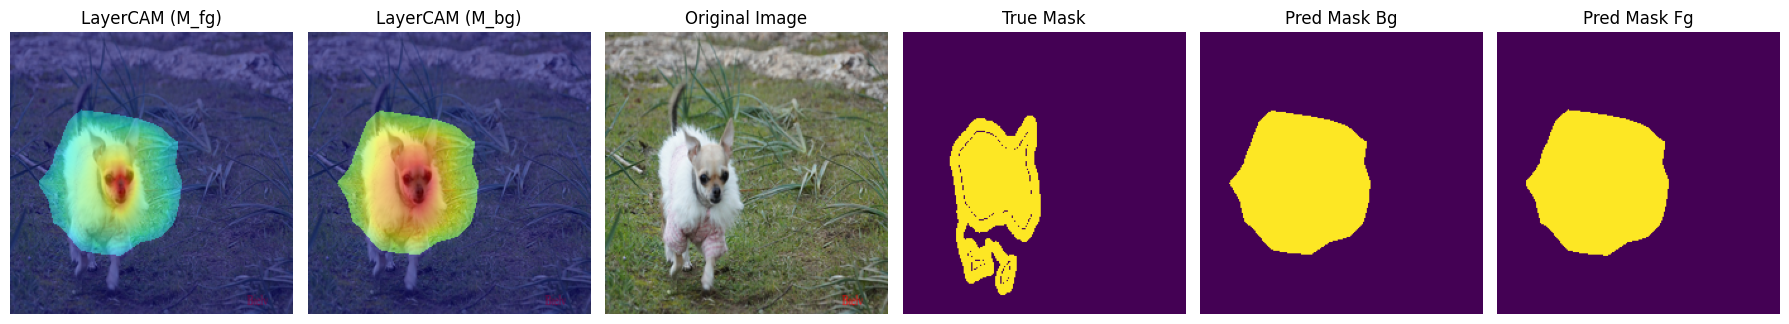

LayerCAM FG: IoU: 0.546 | Acc: 0.736
LayerCAM BG: IoU: 0.531 | Acc: 0.728


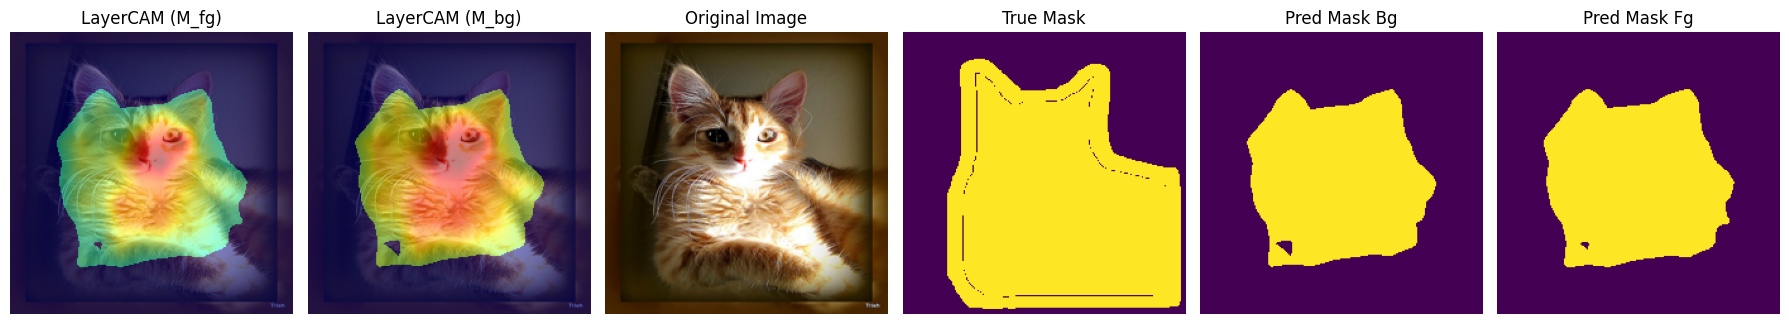

LayerCAM FG: IoU: 0.743 | Acc: 0.921
LayerCAM BG: IoU: 0.751 | Acc: 0.924


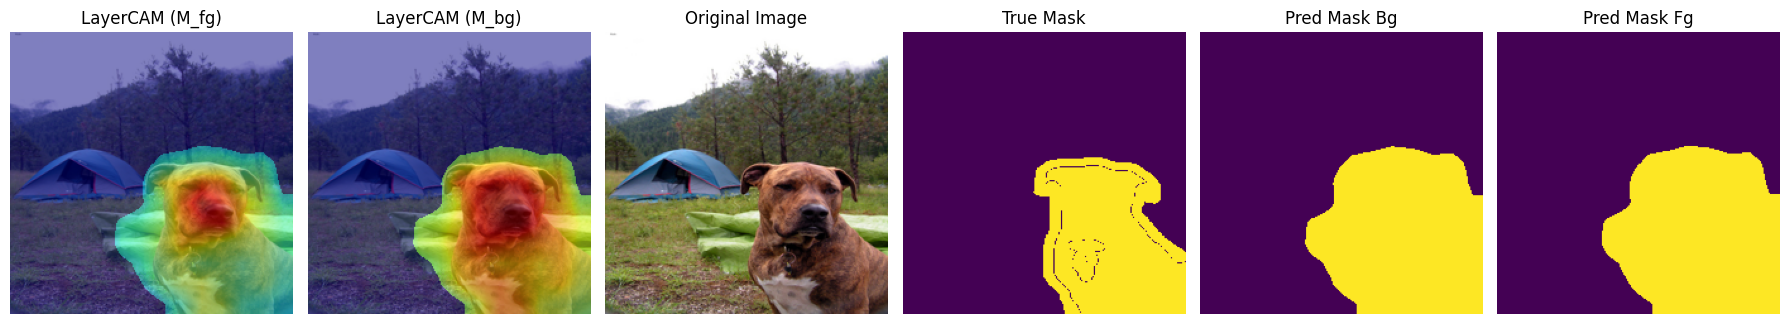

LayerCAM FG: IoU: 0.653 | Acc: 0.839
LayerCAM BG: IoU: 0.647 | Acc: 0.836


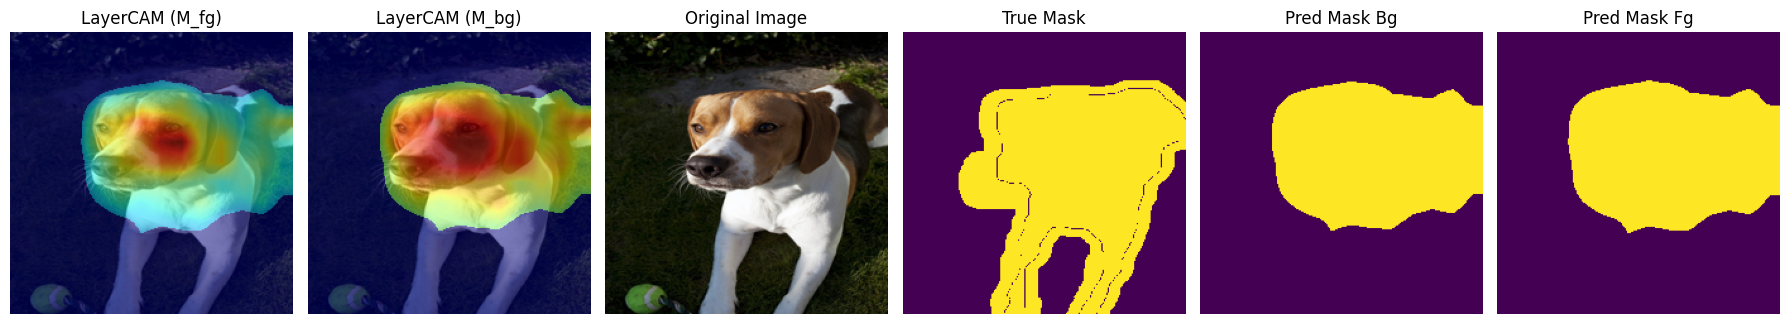

LayerCAM FG: IoU: 0.482 | Acc: 0.744
LayerCAM BG: IoU: 0.480 | Acc: 0.745


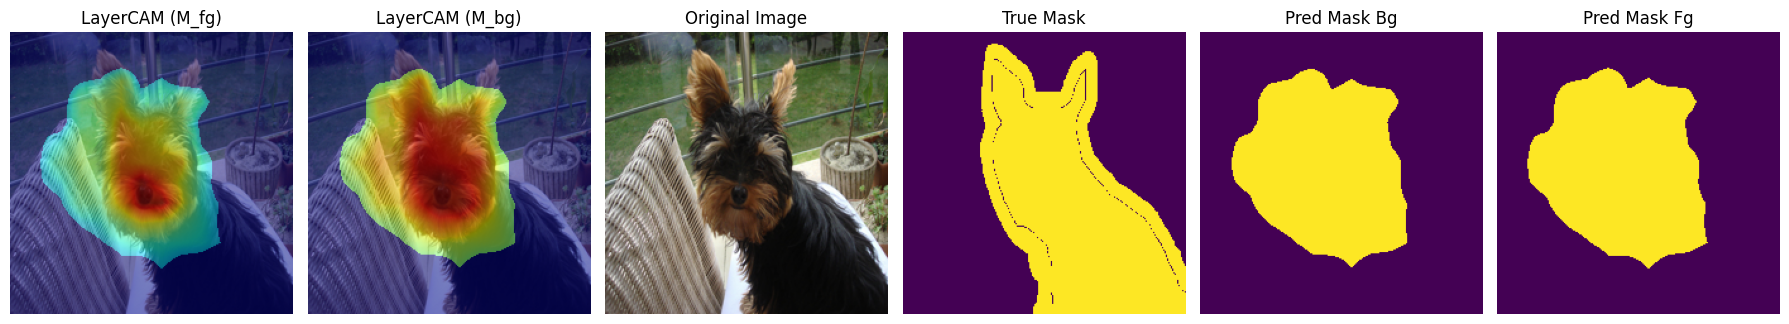

LayerCAM FG: IoU: 0.657 | Acc: 0.869
LayerCAM BG: IoU: 0.661 | Acc: 0.872


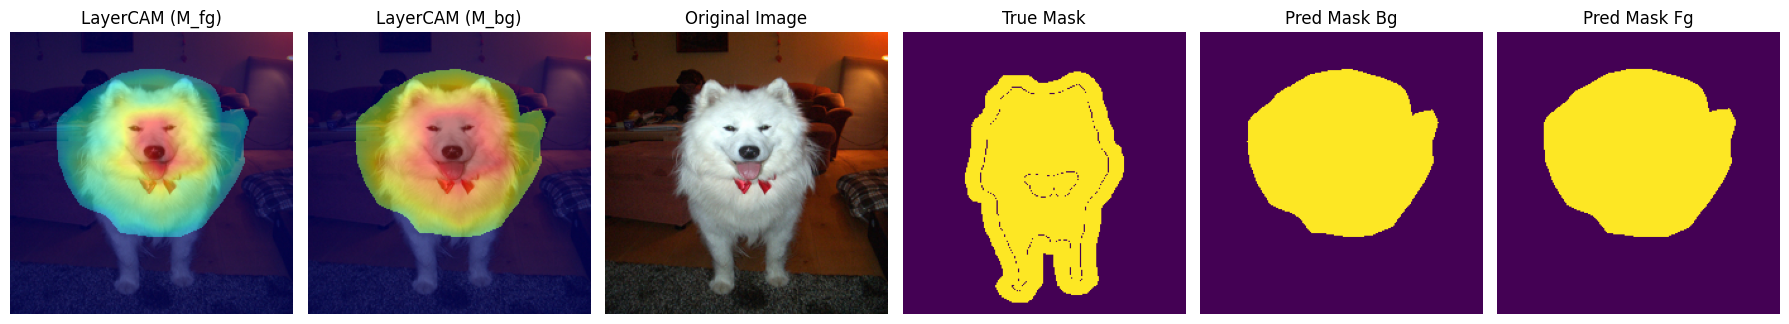

In [ ]:
from os import PRIO_PROCESS
p = 0
layercam_gen = LayerCAMGenerator(classifier, target_layer_names=["layer3", "layer4"])  # f2, f3, f4
device = "cuda"
import cv2

for img, (label, true_mask) in test_loader:
    img = img[0].to(device)  # (3, H, W)
    true_mask = true_mask[0].to(device)
    for i in range(len(true_mask)):
        for j in range(len(true_mask[i])):
          for k in range(len(true_mask[i][j])):
            if true_mask[i][j][k] == 2 or true_mask[i][j][k] == 0:
              true_mask[i][j][k] = 0
            else:
              true_mask[i][j][k] = 1

    label = label[0].item() if isinstance(label[0], torch.Tensor) else label[0]

    valid_class_indices = [label]

    ### --- LAYERCAM GENERATOR ---
    class_tensor = torch.tensor(valid_class_indices).to(device)
    layercam_output = layercam_gen.generate(img, class_idx=class_tensor, alpha=1.0)  # (1, H, W)
    layercam_bg, _ = layercam_gen.generate_bg_cam(img, class_tensor, alpha=1.9)

    layercam = layercam_output.squeeze(0)  # (H, W)
    layercam[layercam < 0.3] = 0.0

    layercam_bg[layercam_bg < 0.5] = 0.0

    pred_bg_mask = torch.zeros_like(layercam_bg).long()
    pred_bg_mask[layercam_bg > 0.0] = 1

    pred_fg_mask = torch.zeros_like(layercam).long()
    pred_fg_mask[layercam > 0.0] = 1

    # # Resize if needed
    if pred_bg_mask.shape != true_mask.shape:
        pred_bg_mask = F.interpolate(pred_bg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()
        #pred_bg_mask = F.interpolate(pred_bg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

    iou_bg, acc_bg = compute_iou_and_acc(pred_bg_mask, true_mask)
    iou_fg, acc_fg = compute_iou_and_acc(pred_fg_mask, true_mask)

    # Visualize overlays
    layercam_fg_overlay = overlay_cam_on_image(img, layercam, alpha=0.5, colormap='jet')
    layercam_bg_overlay = overlay_cam_on_image(img, layercam_bg, alpha=0.5, colormap='jet')

    # Plots
    fig, ax = plt.subplots(1, 6, figsize=(18, 6))

    ax[0].imshow(layercam_fg_overlay)
    ax[0].set_title("LayerCAM (M_fg)")
    print(f"LayerCAM FG: IoU: {iou_fg:.3f} | Acc: {acc_fg:.3f}")
    ax[0].axis('off')

    ax[1].imshow(layercam_bg_overlay)
    ax[1].set_title("LayerCAM (M_bg)")
    print(f"LayerCAM BG: IoU: {iou_bg:.3f} | Acc: {acc_bg:.3f}")
    ax[1].axis('off')

    ax[2].imshow(img.cpu().permute(1, 2, 0).numpy())
    ax[2].set_title("Original Image")
    ax[2].axis('off')

    ax[3].imshow(true_mask.cpu().permute(1, 2, 0).numpy())
    ax[3].set_title("True Mask")
    ax[3].axis('off')

    ax[4].imshow(pred_bg_mask.cpu().numpy())
    ax[4].set_title("Pred Mask Bg")
    ax[4].axis('off')

    ax[5].imshow(pred_fg_mask.cpu().numpy())
    ax[5].set_title("Pred Mask Fg")
    ax[5].axis('off')


    plt.tight_layout()
    plt.show()

    if p == 5:
        break
    p += 1

In [15]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import numpy as np

class PseudoSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(img_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

def joint_transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)

    return image, mask


In [16]:
import shutil

def evaluate_layercam_on_test_set(layercam_gen, test_loader, alpha=1.0, cam_thresh=0.3):
    """
    Evaluates LayerCAM and standard CAM foreground masks on the test set using IoU and pixel accuracy.
    """
    ious_fg, accs_fg = [], []
    ious_bg, accs_bg = [], []

    for i, (img, (label, true_mask)) in enumerate(test_loader):
        img = img[0].cuda()
        true_mask = true_mask[0].cuda()

        # Binarize true mask: class 1 = foreground
        true_mask = (true_mask == 1).long()
        label = label[0].item() if isinstance(label[0], torch.Tensor) else label[0]
        class_tensor = torch.tensor([label]).to(img.device)

        # Generate CAM masks
        layercam_output = layercam_gen.generate(img, class_idx=class_tensor, alpha=alpha)

        layercam = layercam_output.squeeze(0)

        layercam[layercam < cam_thresh] = 0.0

        pred_fg_mask = (layercam > 0.0).long()

        # Resize if needed
        if pred_fg_mask.shape != true_mask.shape:
            pred_fg_mask = F.interpolate(pred_fg_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

        # Compute metrics
        iou_fg, acc_fg = compute_iou_and_acc(pred_fg_mask, true_mask)

        ious_fg.append(iou_fg)
        accs_fg.append(acc_fg)

        if i >= 10:
          break # ablations taking too long so only test 10 images


    print("\n Evaluation of CAMs on test set:")
    print(f" - LayerCam FG: Avg IoU: {sum(ious_fg)/len(ious_fg):.4f} | Acc: {sum(accs_fg)/len(accs_fg):.4f}")


    return {
        "layercam_fg_iou": sum(ious_fg) / len(ious_fg),
        "layercam_fg_acc": sum(accs_fg) / len(accs_fg)
    }



import os
from torchvision.utils import save_image


def generate_pseudo_masks(
    loader,
    layercam_gen,
    cam_thresh=0.3,
    alpha=1.0,
    keep_largest_masks=True,
    run_id="default"):
    """
    Generate pseudo masks using LayerCAM + DenseCRF and save them to disk.
    """
    save_dir = f"/content/pseudo_masks_{run_id}"
    image_save_dir = f"/content/images_{run_id}"
    for d in [save_dir, image_save_dir]:
      if os.path.exists(d):
        shutil.rmtree(d)
      os.makedirs(d)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_id = 0

    for imgs, (labels, _) in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        batch_size = imgs.size(0)

        for i in range(batch_size):

          if img_id >= 500:
            break

          img = imgs[i]
          label = labels[i].item()

          #labels = label.item() if isinstance(label[0], torch.Tensor) else label[0]
          class_tensor = torch.tensor([label]).to(device)

          cam_bg = layercam_gen.generate(img, class_idx = class_tensor, alpha=alpha)
          cam_bg = cam_bg.squeeze(0)
          cam_bg[cam_bg < cam_thresh] = 0.0

          # Convert image for CRF
          image_np = img.detach().cpu().permute(1, 2, 0).numpy()
          image_np = (image_np * 255).astype(np.uint8).clip(0, 255)
          image_np = np.ascontiguousarray(image_np)

          refined_mask = (cam_bg.cpu().numpy() > 0).astype(np.uint8)

          #refined_mask = apply_dense_crf(image_np, cam_bg.cpu().numpy(), compat=crf_compat)

          if keep_largest_masks:
              refined_mask = keep_largest(refined_mask)

          # Save pseudo mask
          mask_path = os.path.join(save_dir, f"{img_id}.png")
          save_image(torch.from_numpy(refined_mask).float().unsqueeze(0), mask_path)

          # Save image
          img_orig = img.cpu().clone()
          img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min())
          save_image(img_orig, os.path.join(image_save_dir, f"{img_id}.png"))

          img_id += 1
    print(f"Pseudo masks saved to: {save_dir}")
    print(f"Images saved to: {image_save_dir}")
    return image_save_dir, save_dir


def train_segmentation_model(run_id, lr=1e-4, num_epochs=10, batch_size=4):
    """
    Train a DeepLabV3 segmentation model on pseudo masks generated in run `run_id`.
    Returns the trained model.
    """
    import torch
    import torch.nn as nn
    import torchvision
    from torch.utils.data import DataLoader

    image_dir = f"/content/images_{run_id}"
    mask_dir = f"/content/pseudo_masks_{run_id}"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = PseudoSegmentationDataset(
        img_dir=image_dir,
        mask_dir=mask_dir,
        transform=joint_transform
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_classes = 2
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_loader:
          if images.size(0) == 1:
            continue
          images, masks = images.to(device), masks.to(device)
          masks = torch.clamp(masks, max=1)  # Ensure binary class labels

          outputs = model(images)['out']
          loss = criterion(outputs, masks.long())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

        final_loss = total_loss

        print(f"[Run {run_id}] Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    return model, final_loss


def evaluate_model(model, test_loader):
    """
    Evaluates a trained segmentation model on a test set.
    Returns average IoU and pixel accuracy.
    """
    import torch
    import torch.nn.functional as F

    device = next(model.parameters()).device
    model.eval()

    ious, accs = [], []
    with torch.no_grad():
        for img, (label, true_mask) in test_loader:
            img = img[0].to(device)
            true_mask = true_mask[0].to(device)
            true_mask = (true_mask == 1).long()  # Binarize

            output = model(img.unsqueeze(0))['out']
            pred_mask = output.argmax(dim=1).squeeze(0)

            # Resize if needed
            if pred_mask.shape != true_mask.shape:
                pred_mask = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=true_mask.shape[-2:], mode='nearest').squeeze().long()

            iou, acc = compute_iou_and_acc(pred_mask, true_mask)
            ious.append(iou)
            accs.append(acc)

    avg_iou = sum(ious) / len(ious)
    avg_acc = sum(accs) / len(accs)

    print(f"\n Model Evaluation on Test Set: IoU = {avg_iou:.4f} | Acc = {avg_acc:.4f}")
    return avg_iou, avg_acc


In [17]:
def run_ablation(cam_method, cam_thresh, alpha, lr, keep_largest, run_id):

    classifier.load_state_dict(torch.load(save_path))
    classifier.eval()

    # cam_gen = CAMGenerator(classifier)
    layercam_gen = LayerCAMGenerator(classifier, target_layer_names=["layer3", "layer4"])

    # 1. (Optional) Evaluate LayerCAMs pre-training
    #evaluate_layercam_on_test_set(layercam_gen, cam_gen, test_loader, alpha, cam_thresh, cam_thresh_bg)

    # 2. Generate pseudo masks
    generate_pseudo_masks(loader, layercam_gen, cam_thresh, alpha, keep_largest, run_id)

    # 3. Train model
    model, final_loss = train_segmentation_model(run_id, lr, num_epochs = 5)

    # 4. Evaluate model
    iou, acc = evaluate_model(model, test_loader)

    return {"run_id": run_id, "iou": iou, "acc": acc, "final_loss": final_loss}

FOR TUSHANN TO RUN:

In [18]:
import itertools

cam_methods = ['LayerCAM']
cam_thresholds = [0.3, 0.5, 0.7]
alphas = [1.0]
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
keep_largest_opts = [True]

# Create all combinations
all_combinations = list(itertools.product(
    cam_methods, cam_thresholds, alphas, lrs, keep_largest_opts
))

In [ ]:
import pandas as pd
from statistics import mean, stdev

results = []
num_repeats = 3

for combo_id, (method, cam_thresh, alpha, lr, keep_largest_opt) in enumerate(all_combinations):
    run_results = []
    for repeat in range(num_repeats):
        run_id = f"abl_{combo_id:03d}_r{repeat}"
        print(f"\n Running {run_id}...")


        result = run_ablation(
                cam_method=method,
                cam_thresh=cam_thresh,
                alpha=alpha,
                lr=lr,
                keep_largest=keep_largest,
                run_id=run_id
            )
        result.update({
                "cam_method": method,
                "cam_thresh": cam_thresh,
                "alpha": alpha,
                "learning_rate": lr,
                "keep_largest": keep_largest_opt
            })
        results.append(result)
        run_results.append(result)

    if run_results:
        ious = [r["iou"] for r in run_results]
        accs = [r["acc"] for r in run_results]
        losses = [r["final_loss"] for r in run_results]

        summary = {
            "combo_id": combo_id,
            "cam_method": method,
            "cam_thresh": cam_thresh,
            "alpha": alpha,
            "learning_rate": lr,
            "keep_largest": keep_largest,
            "iou_mean": mean(ious),
            "iou_std": stdev(ious) if len(ious) > 1 else 0.0,
            "acc_mean": mean(accs),
            "acc_std": stdev(accs) if len(accs) > 1 else 0.0,
            "loss_mean": mean(losses),
            "loss_std": stdev(losses) if len(losses) > 1 else 0.0
        }
        results.append(summary)


 Running abl_000_r0...
Pseudo masks saved to: /content/pseudo_masks_abl_000_r0
Images saved to: /content/images_abl_000_r0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 160MB/s]


[Run abl_000_r0] Epoch 1/5, Loss: 59.9741
[Run abl_000_r0] Epoch 2/5, Loss: 52.8726
[Run abl_000_r0] Epoch 3/5, Loss: 50.9722
[Run abl_000_r0] Epoch 4/5, Loss: 49.8483
[Run abl_000_r0] Epoch 5/5, Loss: 48.6538

 Model Evaluation on Test Set: IoU = 0.1112 | Acc = 0.7214

 Running abl_000_r1...
Pseudo masks saved to: /content/pseudo_masks_abl_000_r1
Images saved to: /content/images_abl_000_r1
[Run abl_000_r1] Epoch 1/5, Loss: 60.5806
[Run abl_000_r1] Epoch 2/5, Loss: 51.9982
[Run abl_000_r1] Epoch 3/5, Loss: 49.8784
[Run abl_000_r1] Epoch 4/5, Loss: 48.9652
[Run abl_000_r1] Epoch 5/5, Loss: 47.4023

 Model Evaluation on Test Set: IoU = 0.4216 | Acc = 0.7121

 Running abl_000_r2...
Pseudo masks saved to: /content/pseudo_masks_abl_000_r2
Images saved to: /content/images_abl_000_r2
[Run abl_000_r2] Epoch 1/5, Loss: 59.0093
[Run abl_000_r2] Epoch 2/5, Loss: 50.7443
[Run abl_000_r2] Epoch 3/5, Loss: 48.8397
[Run abl_000_r2] Epoch 4/5, Loss: 48.2537
[Run abl_000_r2] Epoch 5/5, Loss: 47.2498

 

In [ ]:
df = pd.DataFrame(results)
df.to_csv("ablation_results_False.csv", index=False)